# Exploratory data analysis for Ecommerce Dataset

### Importing packages

In [26]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np


### Load Dataset

In [27]:
customer_df=pd.read_csv('olist_order_payments_dataset.csv')
order_items_df = pd.read_csv('olist_order_items_dataset.csv')
order_payments_df = pd.read_csv('olist_order_payments_dataset.csv')
orders_df=pd.read_csv('olist_orders_dataset.csv')

In [28]:
order_payment_df = pd.merge(orders_df,order_payments_df,on='order_id')
order_payment_df['order_purchase_timestamp'] = pd.to_datetime(order_payment_df['order_purchase_timestamp'],format='%Y-%m-%d %H:%M:%S')
order_payment_df['payment_value'] = order_payment_df['payment_value'].astype(float)
order_payment_df['order_purchase_timestamp'] = order_payment_df['order_purchase_timestamp'].dt.date
daily_sales = order_payment_df.groupby('order_purchase_timestamp')['payment_value'].sum()

In [29]:
daily_sales_df = pd.DataFrame({'date':daily_sales.index, 'ordervalue':daily_sales.values})

In [30]:
daily_sales_df=daily_sales_df[:-1]

In [31]:
daily_sales_df['ordervalue']=pd.to_numeric(daily_sales_df['ordervalue'])
daily_sales_df['date_conv']=pd.to_datetime(daily_sales_df['date'])

In [32]:
daily_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632 entries, 0 to 631
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        632 non-null    object        
 1   ordervalue  632 non-null    float64       
 2   date_conv   632 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 14.9+ KB


In [33]:
daily_sales_df.head()

,date,ordervalue,date_conv
0,2016-09-04,136.23,2016-09-04
1,2016-09-05,75.06,2016-09-05
2,2016-09-13,40.95,2016-09-13
3,2016-10-02,109.34,2016-10-02
4,2016-10-03,595.14,2016-10-03


<Axes: >

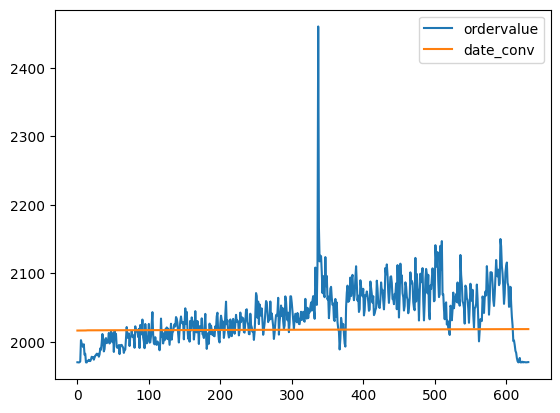

In [34]:
daily_sales_df.plot()

In [41]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [42]:
daily_sales_df['id']='order_value'
#Train test split
split_index = int(len(daily_sales_df) * 0.8)
train_df = daily_sales_df.iloc[:split_index]
test_df = daily_sales_df.iloc[split_index:]

In [44]:
train_data = TimeSeriesDataFrame.from_data_frame(
    train_df,
    id_column="id",
    timestamp_column="date_conv"
)
train_data.head()

date  ordervalue
item_id     timestamp                         
order_value 2016-09-04  2016-09-04      136.23
            2016-09-05  2016-09-05       75.06
            2016-09-13  2016-09-13       40.95
            2016-10-02  2016-10-02      109.34
            2016-10-03  2016-10-03      595.14

In [45]:
test_data = TimeSeriesDataFrame.from_data_frame(
    test_df,
    id_column="id",
    timestamp_column="date_conv"
)

In [46]:
predictor = TimeSeriesPredictor(
    prediction_length=120,
    path="autogluon-m4-daily",
    target="ordervalue",
    eval_metric="MASE",freq="D"
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 505s
AutoGluon will save models to 'autogluon-m4-daily'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.18
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Tue Apr 30 18:22:29 EDT 2024
CPU Count:          8
GPU Count:          0
Memory Avail:       5.99 GB / 15.37 GB (39.0%)
Disk Space Avail:   177.52 GB / 240.42 GB (73.8%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'D',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 120,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'ordervalue',
 'time_limit': 505,
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequen

In [47]:
predictions = predictor.predict(train_data)
predictions.head()

data with frequency 'None' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean           0.1           0.2  \
item_id     timestamp                                              
order_value 2018-05-11  45801.770567  28871.621250  33445.544782   
            2018-05-12  37304.599448  19714.557591  25052.667418   
            2018-05-13  36445.139025  17386.353385  23357.492369   
            2018-05-14  54804.475818  31476.576255  38715.002712   
            2018-05-15  53336.704626  28440.920692  36678.866500   

                                 0.3           0.4           0.5  \
item_id     timestamp                                              
order_value 2018-05-11  39526.587896  41797.399863  45801.770567   
            2018-05-12  31133.227328  33339.019135  37304.599448   
            2018-05-13  29715.149962  32459.768897  36445.139025   
            2018-05-14  45636.806812  49489.688762  54804.475818   
            2018-05-15  43730.160205  47636.295013  53336.704626   

                                 0.6           0.7           0.8           0.9  
item_id     timestamp                                                           
order_value 2018-05-11  49585.030857  52261.172646  58780.579943  66779.072591  
            2018-05-12  41122.346685  44288.203461  51140.713245  59844.340423  
            2018-05-13  40409.140107  44399.902434  51365.436078  60739.273175  
            2018-05-14  58765.145512  62982.088641  69520.023340  77085.651323  
            2018-05-15  57413.236008  62364.626450  69522.412395  77950.926428

In [48]:
from sklearn.model_selection import TimeSeriesSplit


data with frequency 'None' has been resampled to frequency 'D'.


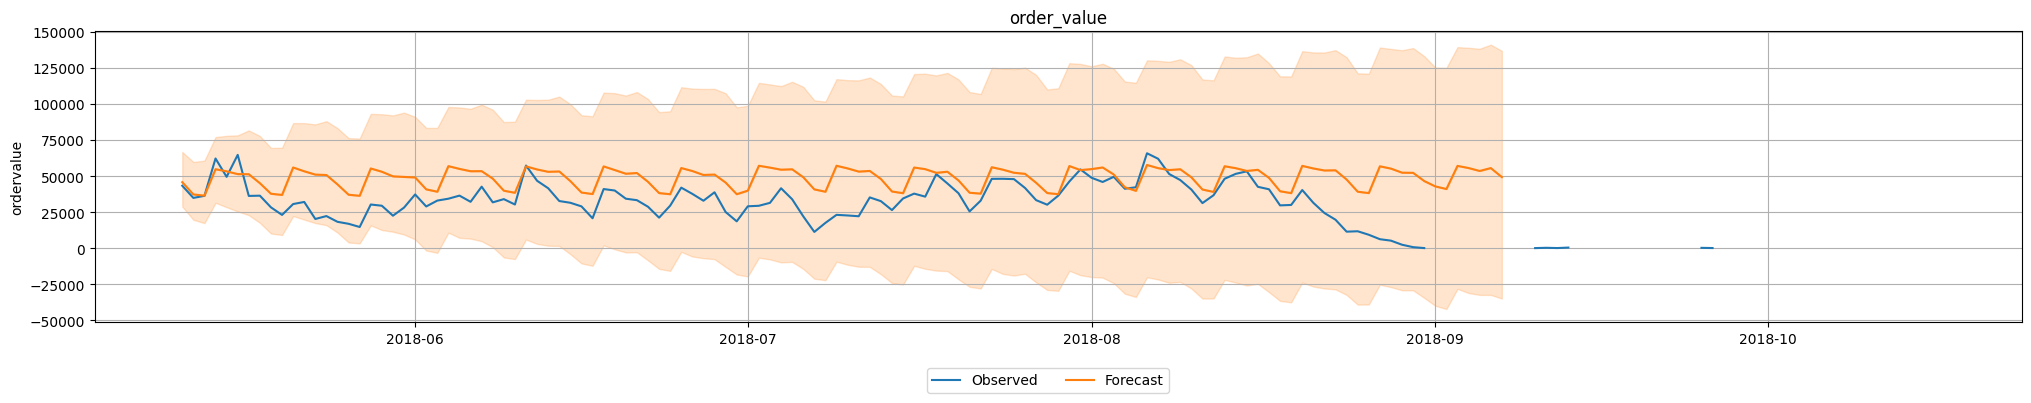

In [50]:
import matplotlib.pyplot as plt

# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=600, max_num_item_ids=4);


In [51]:
test_df.sort_values(by='date_conv')

,date,ordervalue,date_conv,id
0,2016-09-04,136.23,2016-09-04,order_value
1,2016-09-05,75.06,2016-09-05,order_value
2,2016-09-13,40.95,2016-09-13,order_value
3,2016-10-02,109.34,2016-10-02,order_value
4,2016-10-03,595.14,2016-10-03,order_value
...,...,...,...,...
500,2018-05-06,33099.31,2018-05-06,order_value
501,2018-05-07,62568.25,2018-05-07,order_value
502,2018-05-08,55129.38,2018-05-08,order_value
503,2018-05-09,51096.82,2018-05-09,order_value


In [23]:
train_df.head()

,date,ordervalue,date_conv,id
0,2016-09-04,136.23,2016-09-04,order_value
1,2016-09-05,75.06,2016-09-05,order_value
2,2016-09-13,40.95,2016-09-13,order_value
3,2016-10-02,109.34,2016-10-02,order_value
4,2016-10-03,595.14,2016-10-03,order_value
